In [ ]:
import os

num_nodes = 10
num_tasks_per_node = 128
num_forecasters = int(1e6)
current_dir = os.getcwd()

data_folder = "data/"
logs_folder = "logs/"

if not os.path.exists(data_folder):
    os.makedirs(data_folder)

if not os.path.exists(logs_folder):
    os.makedirs(logs_folder)

if num_tasks_per_node > 128:
    print("The number of tasks per node should be less than or equal to 128")
    exit(1)

# Read the launch.sh file
with open('launch.sh', 'r') as file:
    launch_script = file.read()

launch_script = launch_script.format(
    num_nodes=num_nodes,
    num_tasks_per_node=num_tasks_per_node,
    current_dir=current_dir,
    world_size=num_nodes*num_tasks_per_node,
    num_forecasters=num_forecasters
)

# Print the content of the launch.sh file
print(launch_script)

# Save the sbatch script to a temporary file
script_filename = "submit_job.sh"
with open(script_filename, "w") as script_file:
    script_file.write(launch_script)

# Submit the job using the sbatch command
os.system(f"sbatch {script_filename}")

# Remove the temporary file
os.remove(script_filename)

#!/bin/bash -l

#SBATCH --job-name=ensemble_forecasters
#SBATCH --output=logs/output_%j.txt
#SBATCH --error=logs/error_%j.txt
#SBATCH --nodes=10
#SBATCH --ntasks-per-node=128
#SBATCH --ntasks-per-socket=16
#SBATCH --cpus-per-task=1
#SBATCH --time=00:30:00

cd /mnt/aiongpfs/users/lgreco/Development/ML4HPC/ensemble_of_forecasters
eval "$(micromamba shell hook --shell bash)"
micromamba activate ensemble_venv
module load mpi/OpenMPI/4.0.5-GCC-10.2.0
mpirun -n 1280 python ensemble_of_forecasters.py 1000000
Submitted batch job 4361801


(1000000, 5, 2)
(1000000, 2, 6)
(1000000, 1)


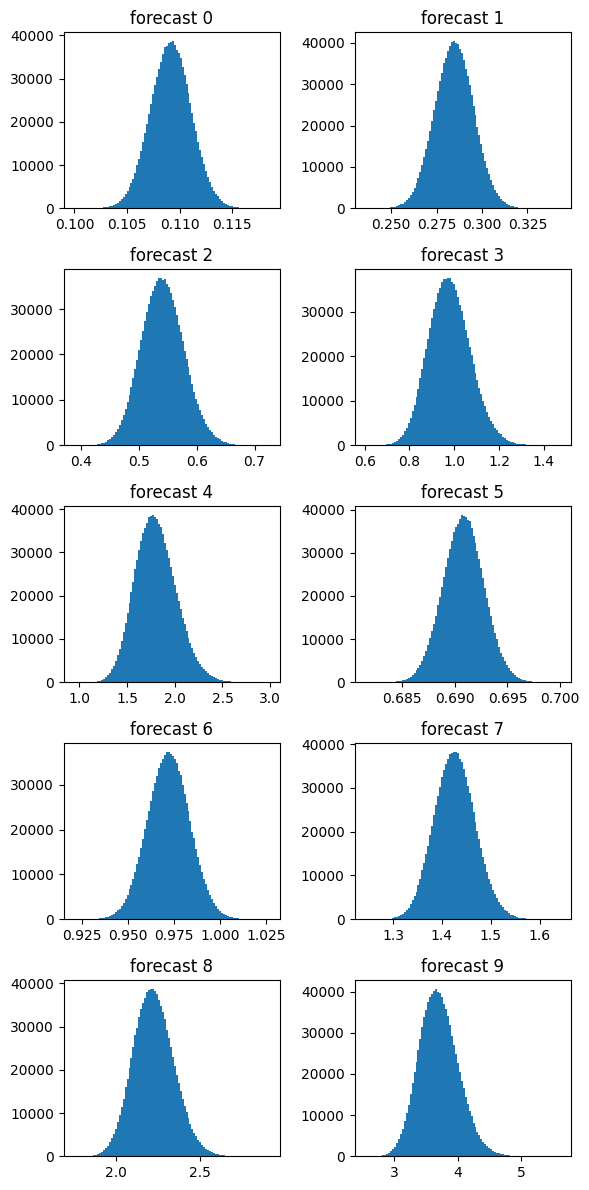

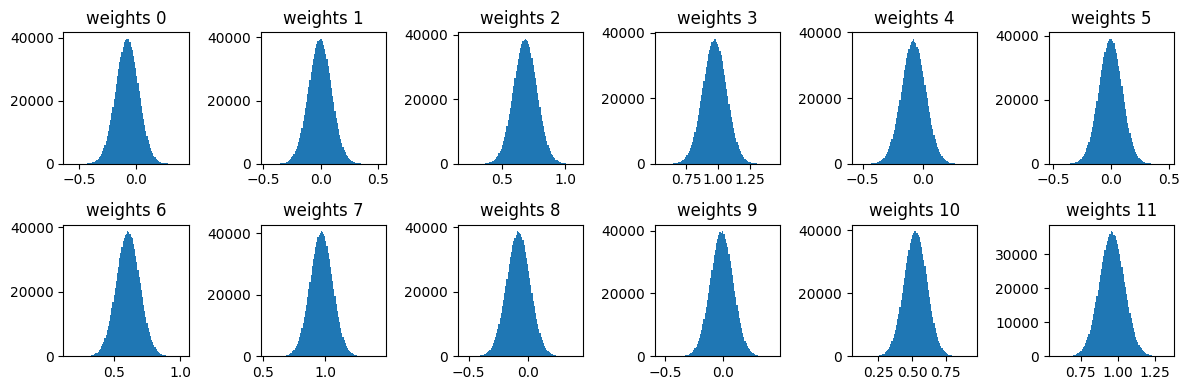

In [ ]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

forecast = np.load(data_folder + 'forecasting.npy')
weights  = np.load(data_folder + 'weights.npy')
biases   = np.load(data_folder + 'biases.npy')

print(forecast.shape)
print(weights.shape)
print(biases.shape)


variable = forecast
fig, axs = plt.subplots(5, 2, figsize=(6, 12))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot histograms in each subplot
for z in range(variable.shape[2]):
    for y in range(variable.shape[1]):
        f_list = []
        for x in range(variable.shape[0]):
            f_list.append(variable[x][y][z])
        axs[z*variable.shape[1]+y].hist(f_list, bins=100)
        axs[z*variable.shape[1]+y].set_title(f'forecast {z*variable.shape[1]+y}')
f_list = []

plt.tight_layout()
plt.show()

variable = weights
fig, axs = plt.subplots(variable.shape[1], variable.shape[2], figsize=(12, 4))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot histograms in each subplot
for z in range(variable.shape[2]):
    for y in range(variable.shape[1]):
        f_list = []
        for x in range(variable.shape[0]):
            f_list.append(variable[x][y][z])
        axs[z*variable.shape[1]+y].hist(f_list, bins=100)
        axs[z*variable.shape[1]+y].set_title(f'weights {z*variable.shape[1]+y}')
f_list = []

plt.tight_layout()
plt.show()
